In [1]:
# imports and random walk definition
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import time

def random_walk(s0, mu, sigma, days):
    dt = 1/365.
    prices = numpy.zeros(days)
    shocks = numpy.zeros(days)
    prices[0] = s0
    for i in range(1, days):
        e = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        prices[i] = prices[i-1] * (1 + e)
    return prices

Text(0,0.5,'Price')

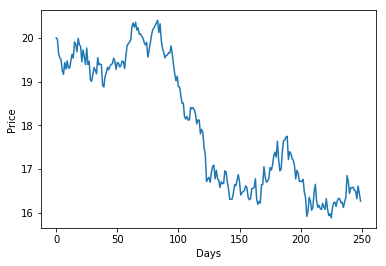

In [6]:
plt.plot(random_walk(20.0, 0.05, 0.2, 250))
plt.xlabel("Days")
plt.ylabel("Price")

In [9]:
# run n MC simulations sequentially

# parameters
strike = 100.
s0 = 100.
r = 0.05
sigma = 0.2
days = 365*4
n = 2000

# simulation results
simulations = numpy.zeros(n)

start_time = time.time()
for i in range(n):
    x = numpy.average(random_walk(s0, r, sigma, days))
    simulations[i] = max(0, x - strike)

# average individual results and discount
p = numpy.average(simulations) * numpy.exp(-r*days/365.)
end_time = time.time()

print(f'Result={round(p, 3)} (took {round(end_time - start_time, 3)}s)')

Result=13.149 (took 9.11s)


In [10]:
# idea: use threads to generate random walks in parallel
# use concurrent.futures.ThreadPoolExecutor
from concurrent.futures import ThreadPoolExecutor

# parameters
strike = 100.
s0 = 100.
r = 0.05
sigma = 0.2
days = 365*4
n = 2000

# simulation results
simulations = numpy.zeros(n)

# list to hold Future instances created by Executor.submit()
# the Future class encapsulates the asynchronous execution of a callable
futures = []

start_time = time.time()
# submit calculations to ThreadPoolExecutor 
with ThreadPoolExecutor(max_workers=2) as executor:
    for i in range(n):
        futures.append(executor.submit(random_walk, s0, r, sigma, days))

# collect results
for i, future in enumerate(futures):
    x = numpy.average(future.result())
    simulations[i] = max(0, x - strike)

# average individual results and discount
p = numpy.average(simulations) * numpy.exp(-r*days/365.)

end_time = time.time()
print(f'Result={round(p, 3)} (took {round(end_time - start_time, 3)}s)')


Result=12.795 (took 47.493s)


In [13]:
# memory-management, refcounting, protection from race-conditions, locks/deadlocks
# ...and the GIL as a pragmatic solution that made Python as popular as it is today
import sys
a = []
a = None
sys.getrefcount(a)

64435

In [ ]:
# idea: use processes to generate random walks in parallel
# use concurrent.futures.ProcessPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import lib

# parameters
strike = 100.
s0 = 100.
r = 0.05
sigma = 0.2
days = 365*4
n = 3000

# simulation results
simulations = numpy.zeros(n)

# list to hold Future instances created by Executor.submit()
# the Future class encapsulates the asynchronous execution of a callable
futures = []


start_time = time.time()
# submit calculations to ThreadPoolExecutor 
with ProcessPoolExecutor(max_workers=2) as executor:
    for i in range(n):
        futures.append(executor.submit(lib.random_walk, s0, r, sigma, days))

# collect results
for i, future in enumerate(futures):
    x = numpy.average(future.result())
    simulations[i] = max(0, x - strike)

# average individual results and discount
p = numpy.average(simulations) * numpy.exp(-r*days/365.)

end_time = time.time()
print(f'Result={round(p, 3)} (took {round(end_time - start_time, 3)}s)')




In [2]:
# set celerybroker url (redis)
# restart kernel when switching

# local: redis://localhost:6379/0
# %set_env CELERY_BROKER_URL=redis://localhost:6379/0
# %set_env CELERY_RESULT_BACKEND=redis://localhost:6379/0

# cloud: redis://185.207.112.230:6379/0
%set_env CELERY_BROKER_URL=redis://185.207.112.230:6379/0
%set_env CELERY_RESULT_BACKEND=redis://185.207.112.230:6379/0



env: CELERY_BROKER_URL=redis://185.207.112.230:6379/0
env: CELERY_RESULT_BACKEND=redis://185.207.112.230:6379/0


In [3]:
# import celery task
# this assumes access to the celery app's code base
# which is not necessary: app.send_task('average_of_random_walk', kwargs={'s0': ...})
from tasks import average_of_random_walk

# run a task remotely (see logs)
task = average_of_random_walk.s(s0=100, mu=0.05, sigma=0.2, days=365*4).delay()


# print task id and status
print(task.id)
print(task.status)

# wait for task to finish and get result
# print(task.get())
# print(task.status)

66cfcfb3-cecf-4ccb-a4b3-92834d1db25b
PENDING


In [8]:
task.get()

92.40350218360928

In [5]:
# Celery workflow primitives: chains and group
from celery import chain, group
from tasks import add
from tasks import average_of_random_walk

# task = chain(add.s(2,2), add.s(5), add.s(10)).delay()
# print(task.get())

task = group([average_of_random_walk.s(s0=100, mu=0.05, sigma=0.2, days=365*4) for i in range(10)]).delay()
print(task.get())

[142.09630562449493, 87.399617538753, 92.40350218360928, 87.399617538753, 116.9719402143573, 116.9719402143573, 113.00612571739451, 113.00612571739451, 142.15851247762578, 134.75526919356864]


In [4]:
import time
import numpy
from celery import chord, group
from tasks import average_of_random_walk, average

n = 1000
strike = 100.
s0 = 100.
r = 0.05
sigma = 0.2
days = 365*4

start_time = time.time()
result = chord([average_of_random_walk.s(100, 0.05, 0.2, 365*4) for i in range(n)])(average.s()).get()
p = result * numpy.exp(-r*days/365.)

end_time = time.time()
print(f'Result={round(p, 3)} (took {round(end_time - start_time, 3)}s)')


Result=90.446 (took 138.613s)
